In [21]:
# Import NumPy for numerical operations
import numpy as np

# Import PyTorch for building and training neural networks
import torch
import torch.nn as nn
import torch.optim as optim

# Import Matplotlib for plotting
import matplotlib.pyplot as plt


# Import the time module to time our training process
import time

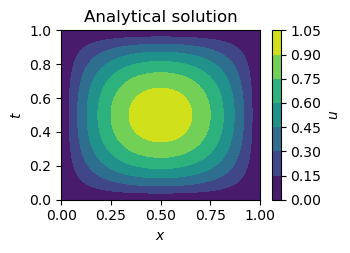

In [22]:

# Define a function for the analytical solution of the 1D wave equation
def analytic_sol_func(x1, x2):
    #return torch.sin(x1) * torch.cos(x2) + 0.5 * torch.cos(2*x1) * torch.cos(2*x2) + 0.25 * torch.cos(4*x1) * torch.cos(4*x2)
    return 16*(1 - x1) * x1 * (1 - x2) * x2
    #return x1*x2*(1-x1)*(1-x2)*torch.exp(x1-x2)

# Check if CUDA is available and set PyTorch device to GPU if it is
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate training data in PyTorch
x_pt = torch.linspace(0, 1, 100, device=device)  # x data (PyTorch tensor), shape=(100,)
t_pt = torch.linspace(0, 1, 100, device=device)  # t data (PyTorch tensor), shape=(100,)

# Create a grid of x and t values
t_grid, x_grid = torch.meshgrid(t_pt, x_pt) # x and t data (PyTorch tensor), shape=(100, 100)

# Calculate u values using the analytical solution function
u_grid = analytic_sol_func(t_grid, x_grid) # u data (PyTorch tensor), shape=(100, 100)

# Move data to CPU for plotting
t_grid_np = t_grid.cpu().numpy()
x_grid_np = x_grid.cpu().numpy()
u_grid_np = u_grid.cpu().numpy()

# Create a figure for the plot
fig = plt.figure(figsize=(3.2, 2.2))

# Plot the u values as a function of t and x
plt.contourf(t_grid_np, x_grid_np, u_grid_np, origin='lower')
plt.colorbar(label='$u$')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Analytical solution')

# Display the plot
plt.show()

In [23]:
# Check if CUDA is available and set PyTorch device to GPU if it is
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Conversion of the grid data to PyTorch tensors
x = torch.from_numpy(x_grid_np).float().unsqueeze(-1).to(device)
t = torch.from_numpy(t_grid_np).float().unsqueeze(-1).to(device)
u = torch.from_numpy(u_grid_np).float().unsqueeze(-1).to(device)

# Concatenation of x and t to form the input data
input_data = torch.cat((x, t), dim=-1)

In [24]:
# Check if CUDA is available and set PyTorch device to GPU if it is
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a neural network class with three fully connected layers
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(2, 32)
        self.layer2 = nn.Linear(32, 32)
        self.output_layer = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.tanh(self.layer1(x))
        x = torch.tanh(self.layer2(x))
        x = self.output_layer(x)
        return x
    
# Create an instance of the neural network and move it to the GPU
neural_net = NeuralNetwork().to(device)

# Define an optimizer (LBFGS) for training the network
optimizer = torch.optim.LBFGS(neural_net.parameters(), lr=1)

# Define a loss function (Mean Squared Error) for training the network
loss_func = nn.MSELoss()

# Initialize a list to store the loss values
loss_values = []

# Start the timer
start_time = time.time()

# Training the neural network
for i in range(101):
    def closure():
        optimizer.zero_grad()   # clear gradients for next train
        prediction = neural_net(input_data.to(device))     # input x and predict based on x
        loss = loss_func(prediction, u.to(device))     # must be (1. nn output, 2. target)
        loss.backward()         # backpropagation, compute gradients
        return loss

    optimizer.step(closure)
    
    # Append the current loss value to the list
    loss_values.append(closure().item())
    
    if i % 10 == 0:  # print every 100 iterations
        print(f"Iteration {i}: Loss {loss_values[-1]}")

# Stop the timer and calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time} seconds")

Iteration 0: Loss 0.0778244212269783
Iteration 10: Loss 6.91784152877517e-05
Iteration 20: Loss 2.6318612071918324e-05
Iteration 30: Loss 1.8062004528474063e-05
Iteration 40: Loss 1.0162188118556514e-05
Iteration 50: Loss 4.910162715532351e-06
Iteration 60: Loss 4.65875564259477e-06
Iteration 70: Loss 4.65875564259477e-06
Iteration 80: Loss 4.65875564259477e-06
Iteration 90: Loss 4.65875564259477e-06
Iteration 100: Loss 4.65875564259477e-06
Training time: 30.944239377975464 seconds


In [25]:
# Get final predictions on training data
final_predictions = neural_net(input_data.to(device))

# Calculate the final loss (error)
final_loss = loss_func(final_predictions, u.to(device))

print(f"Final Training Loss: {final_loss.item()}")

Final Training Loss: 4.65875564259477e-06


In the following code block, we plot the loss values recorded during the training process. This plot helps us visualize how the loss decreases over time, indicating that our neural network is learning to approximate the wave function more accurately with each iteration.

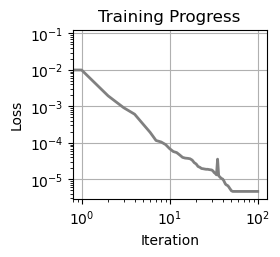

In [26]:
# Create a figure for the plot
fig = plt.figure(figsize=(2.5, 2.2))

# Plot the loss values recorded during training
plt.loglog(loss_values, color='gray', linewidth=2)

# Set the labels for the x and y axes
plt.xlabel('Iteration')
plt.ylabel('Loss')

# Set the title for the plot
plt.title('Training Progress')

# Display the grid
plt.grid(True)

# Display the plot
plt.show()

In the following code block, we use the trained neural network to generate predictions for `u` based on the input data. We then plot these predicted `u` values and the difference between the predicted and actual `u` values. This allows us to visually assess the performance of our neural network.

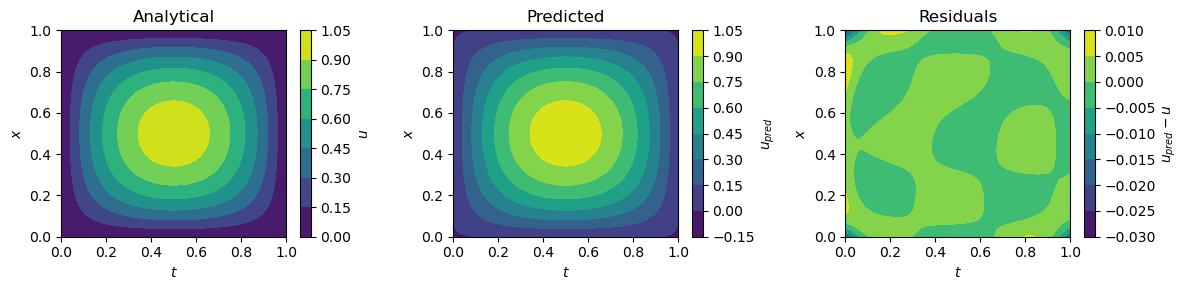

In [27]:
# Generate predictions using the neural network and reshape to match grid
u_pred = neural_net(input_data.to(device)).cpu().detach().numpy().reshape(x_grid.shape)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

# Define a function to plot a contour graph
def plot_contour(ax, x, y, z, title, label):
    im = ax.contourf(x, y, z, origin='lower')
    ax.set_title(title)
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    fig.colorbar(im, ax=ax, label=label)
    #ax.contour(x, y, z, levels=20, colors='white', alpha=0.2, linestyles='solid')

# Plot the predicted u values
plot_contour(axs[0], t_grid.cpu(), x_grid.cpu(), u_grid.cpu(), 'Analytical', '$u$')

# Plot the predicted u values
plot_contour(axs[1], t_grid.cpu(), x_grid.cpu(), u_pred, 'Predicted', '$u_{pred}$')

# Plot the residuals between the predicted and analytical u values
residuals = u_pred - u_grid.cpu().numpy()
plot_contour(axs[2], t_grid.cpu(), x_grid.cpu(), residuals, 'Residuals', '$u_{pred}-u$')

plt.tight_layout()

# Display the plot
plt.show()